# План работы

1. Подготовить данные;
   * Откроем файлы и изучим их
   * Проверим, что эффективность обогащения рассчитана правильно.
     * Вычислим её на обучающей выборке для признака rougher.output.recovery.
     * Найдём MAE между вашими расчётами и значением признака. Опишем выводы.
   * Проанализируем признаки, недоступные в тестовой выборке.
     * Что это за параметры? К какому типу относятся?
   * Проведем предобработку данных
2. Проведем исследовательский анализ данных;
   * Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишем выводы
   * Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной
   * Напишем функцию для вычисления итоговой sMAPE
3. Построим и обучить модель.
   * Обучим разные модели и оцените их качество кросс-валидацией. Выберем лучшую модель и проверьте её на тестовой выборке. Опишем выводы

## Подготовить данные

### Откроем файлы и изучим их

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from numpy.random import RandomState
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.dummy import DummyRegressor

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression


In [63]:
df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')

In [64]:
print(df_full.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [65]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [66]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [67]:
print(df_full.isnull().sum().sort_values(ascending=False).head(30))

secondary_cleaner.output.tail_sol           1748
rougher.input.floatbank11_xanthate           453
rougher.state.floatbank10_e_air              436
primary_cleaner.output.concentrate_sol       370
secondary_cleaner.state.floatbank2_a_air     220
final.output.concentrate_sol                 211
rougher.input.feed_size                      145
primary_cleaner.output.concentrate_pb        116
primary_cleaner.input.xanthate               104
final.output.tail_pb                         101
rougher.input.feed_pb                        100
rougher.input.feed_sol                        99
primary_cleaner.output.tail_sol               62
rougher.input.floatbank11_sulfate             44
primary_cleaner.input.depressant              37
rougher.input.floatbank10_sulfate             34
primary_cleaner.input.sulfate                 24
rougher.output.concentrate_sol                23
secondary_cleaner.state.floatbank2_b_air      23
primary_cleaner.output.tail_pb                21
secondary_cleaner.st

### Проверим, что эффективность обогащения рассчитана правильно

#### Вычислим её на обучающей выборке для признака rougher.output.recovery.

* C — доля золота в концентрате после флотации/очистки; rougher.output.concentrate_au
* F — доля золота в сырье/концентрате до флотации/очистки; rougher.input.feed_au
* T — доля золота в отвальных хвостах после флотации/очистки. rougher.output.tail_au 

In [68]:
C_train = df_train['rougher.output.concentrate_au']
F_train = df_train['rougher.input.feed_au']
T_train = df_train['rougher.output.tail_au']

recovery_train = df_train['rougher.output.recovery']

In [69]:
def recovery(C, F, T):
    result = (C*(F-T))/(F*(C-T))*100
    return result

In [70]:
print(recovery(C_train, F_train, T_train).median())
print(recovery_train.median())

85.29946209869779
85.2994620986978


Вывод: эффективность обогащения рассчитана правильно

#### 1.2.2 Найдём MAE между вашими расчётами и значением признака. Опишем выводы.

In [71]:
print(mean_absolute_error(recovery_train, recovery(C_train, F_train, T_train)))

9.73512347450521e-15


Вывод: средняя абсолютная ошибка (MAE) равна 9.73512347450521e-15

### Проанализируем признаки, недоступные в тестовой выборке.

Что это за параметры? К какому типу относятся?

In [72]:
print('Количество признаков в полной выборке', df_full.shape)
print('Количество признаков в тестовой выборке',df_test.shape)
print('Количество признаков в обучающей выборке',df_train.shape)
print('-'*45)
print('Количество признаков отсутствующих в тестовой выборке:', 87-53)

Количество признаков в полной выборке (19439, 87)
Количество признаков в тестовой выборке (5290, 53)
Количество признаков в обучающей выборке (14149, 87)
---------------------------------------------
Количество признаков отсутствующих в тестовой выборке: 34


In [73]:
print('Признаки, недоступные в тестовой выборке')
set(df_train.columns) - set(df_test.columns)

Признаки, недоступные в тестовой выборке


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Предоположу что недостает признаком, которые вычисляются на более поздних этапах. Но так же и не достает целевых признаков ('rougher.output.recovery','final.output.recovery')

### Проведем предобработку данных

In [74]:
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')
# изменим формат даты

In [75]:
df_test = df_test.merge(df_full.loc[:, ['date','rougher.output.recovery','final.output.recovery']], on='date')
#перенесем целевые признаки из df_full
print('Количество признаков в тестовой выборке',df_test.shape)

Количество признаков в тестовой выборке (5290, 55)


In [76]:
df_train = df_train.ffill(axis=0)
df_test = df_test.ffill(axis=0)
df_full = df_full.ffill(axis=0)
#заполним пропущенные значения функцией ffill

## Проведем исследовательский анализ данных

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

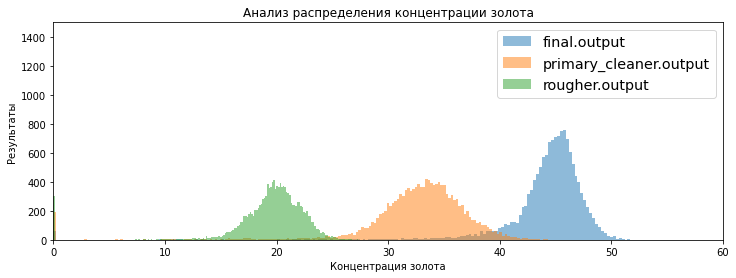

In [77]:
plt.figure(figsize=[12,4])
plt.hist(df_train['final.output.concentrate_au'], bins=200, label = 'final.output', alpha=0.5)
plt.hist(df_train['primary_cleaner.output.concentrate_au'], bins=200, label = 'primary_cleaner.output', alpha=0.5)
plt.hist(df_train['rougher.output.concentrate_au'], bins=200, label = 'rougher.output', alpha=0.5)

plt.xlim([0, 60])
plt.ylim([0, 1500])
plt.xlabel("Концентрация золота")
plt.ylabel("Результаты")
plt.title("Анализ распределения концентрации золота")
plt.legend(loc='upper right', fontsize='x-large')
plt.show()

Концентрация золота повышается с кажым этапом

In [78]:
df_train = df_train[
    (df_train['final.output.concentrate_au'] != 0) & 
    (df_train['primary_cleaner.output.concentrate_au'] != 0) & 
    (df_train['rougher.output.concentrate_au'] != 0)]

Сразу удалим аномалии

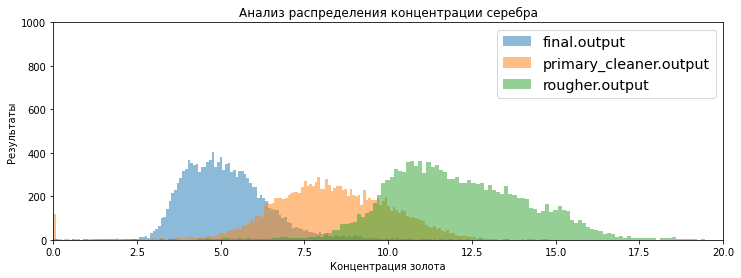

In [79]:
plt.figure(figsize=[12,4])

plt.hist(df_train['final.output.concentrate_ag'], bins=200, label = 'final.output', alpha=0.5)
plt.hist(df_train['primary_cleaner.output.concentrate_ag'], bins=200, label = 'primary_cleaner.output', alpha=0.5)
plt.hist(df_train['rougher.output.concentrate_ag'], bins=200, label = 'rougher.output', alpha=0.5)
plt.xlim([0, 20])
plt.ylim([0, 1000])
plt.xlabel("Концентрация золота")
plt.ylabel("Результаты")
plt.title("Анализ распределения концентрации серебра")
plt.legend(loc='upper right', fontsize='x-large')
plt.show()

Концентрация серебра понижается

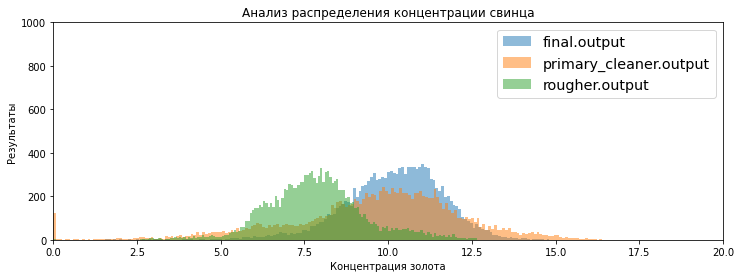

In [80]:
plt.figure(figsize=[12,4])
plt.hist(df_train['final.output.concentrate_pb'], bins=200, label = 'final.output', alpha=0.5)
plt.hist(df_train['primary_cleaner.output.concentrate_pb'], bins=200, label = 'primary_cleaner.output', alpha=0.5)
plt.hist(df_train['rougher.output.concentrate_pb'], bins=200, label = 'rougher.output', alpha=0.5)
plt.xlim([0, 20])
plt.ylim([0, 1000])
plt.xlabel("Концентрация золота")
plt.ylabel("Результаты")
plt.title("Анализ распределения концентрации свинца")
plt.legend(loc='upper right', fontsize='x-large')
plt.show()

Концентрация свинца сначала увеличивается на этапе флотации, после чего остается примерно на одном уровне.

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

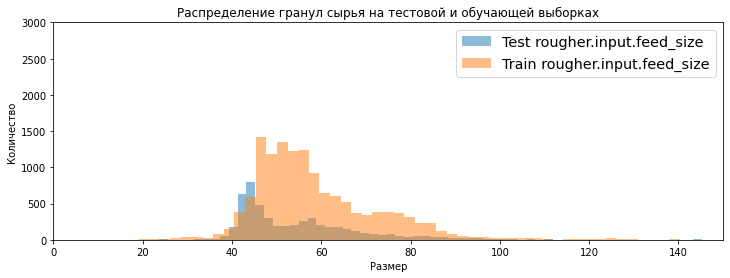

In [81]:
plt.figure(figsize=[12,4])
plt.hist(df_test['rougher.input.feed_size'], bins=200, label = 'Test rougher.input.feed_size', alpha=0.5)
plt.hist(df_train['rougher.input.feed_size'], bins=200, label = 'Train rougher.input.feed_size', alpha=0.5)
plt.xlim([0, 150])
plt.ylim([0, 3000])
plt.xlabel("Размер")
plt.ylabel("Количество")
plt.title("Распределение гранул сырья на тестовой и обучающей выборках")
plt.legend(loc='upper right', fontsize='x-large')
plt.show()

Распределение гранул сырья на тестовой и обущающей выборках со смещением вправо

In [82]:
df_test.shape
5290*54

285660

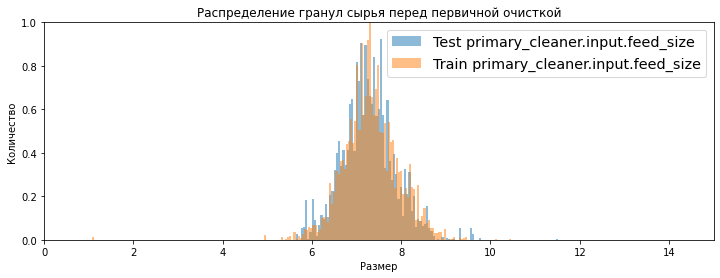

In [83]:
plt.figure(figsize=[12,4])
plt.hist(df_test['primary_cleaner.input.feed_size'], 
         bins=200, 
         label = 'Test primary_cleaner.input.feed_size',
         density=True,
         alpha=0.5)
plt.hist(df_train['primary_cleaner.input.feed_size'], 
         bins=200, 
         label = 'Train primary_cleaner.input.feed_size',
         density=True,
         alpha=0.5)
plt.xlim([0, 15])
plt.ylim([0, 1])
plt.xlabel("Размер")
plt.ylabel("Количество")
plt.title("Распределение гранул сырья перед первичной очисткой")
plt.legend(loc='upper right', fontsize='x-large')
plt.show()

Значения находятся в одном диапозоне, значимых различий между распределениями нет

In [84]:
final_output_concentrate_sum = (df_train['final.output.concentrate_au'] + 
                                df_train['final.output.concentrate_ag'] + 
                                df_train['final.output.concentrate_pb'] +
                                df_train['final.output.concentrate_sol'])
primary_cleaner_output_concentrate_sum = (df_train['primary_cleaner.output.concentrate_au'] + 
                                          df_train['primary_cleaner.output.concentrate_ag'] + 
                                          df_train['primary_cleaner.output.concentrate_pb'] +
                                          df_train['primary_cleaner.output.concentrate_sol'])
rougher_output_concentrate_sum = (df_train['rougher.output.concentrate_au'] + 
                                  df_train['rougher.output.concentrate_ag'] + 
                                  df_train['rougher.output.concentrate_pb'] +
                                  df_train['rougher.output.concentrate_sol'])

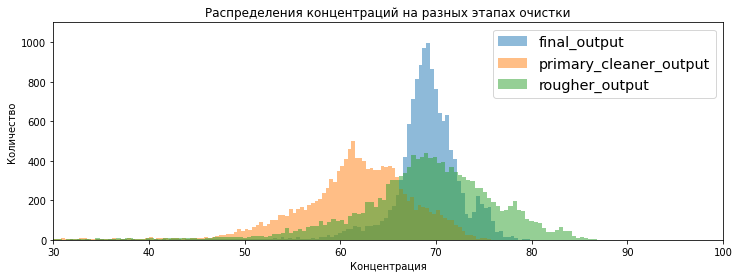

In [85]:
plt.figure(figsize=[12,4])
plt.hist(final_output_concentrate_sum, bins=200, label = 'final_output', alpha=0.5)
plt.hist(primary_cleaner_output_concentrate_sum, bins=200, label = 'primary_cleaner_output', alpha=0.5)
plt.hist(rougher_output_concentrate_sum, bins=200, label = 'rougher_output', alpha=0.5)
plt.xlim([30, 100])
plt.ylim([0, 1100])
plt.xlabel("Концентрация")
plt.ylabel("Количество")
plt.legend(loc='upper right', fontsize='x-large')
plt.title("Распределения концентраций на разных этапах очистки")
plt.show()

Концентрация веществ увеличивается к финальному этапу

### Напишем функцию для вычисления итоговой sMAPE

In [86]:
def smape(target, pred):
    smape = (1/len(target))*np.sum((np.abs(target - pred))/( (np.abs(target)+np.abs(pred))/2))*100
    return smape

In [87]:
smape_scorer = make_scorer(smape, greater_is_better = False)

## Построим и обучить модель.

Подготовим признаки

In [88]:
extra_sign = set(df_train.columns) - set(df_test.columns)
extra_sign_good = extra_sign - set(['rougher.output.recovery','final.output.recovery'])
df_train = df_train.drop(columns=extra_sign_good, axis=1)
#удалим признаки, отсутсвующие в тестовой выборке

In [89]:
df_train = df_train.drop('date', axis=1)
df_test = df_test.drop('date', axis=1)
# удалим столбцы с датой

In [90]:
print(df_train.columns.shape)
print(df_test.columns.shape)

(54,)
(54,)


In [91]:
features_train = df_train.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_train = df_train['rougher.output.recovery']
target_train_final = df_train['final.output.recovery']

### LinearRegression

In [92]:
%%time
model_lr = LinearRegression()
smape_rougher = cross_val_score(model_lr, features_train, target_train, scoring=smape_scorer, cv=5)
smape_rougher_final_lr = smape_rougher.mean()

model_lr_final = LinearRegression()
smape_final = cross_val_score(model_lr_final, features_train, target_train_final, scoring=smape_scorer, cv=5)
final_smape_final_lr = smape_final.mean()

CPU times: user 850 ms, sys: 1.97 s, total: 2.82 s
Wall time: 2.83 s


In [93]:
result_smape_lr = (0.25*smape_rougher_final_lr + 0.75*final_smape_final_lr)*(-1)

### DecisionTreeRegressor

In [94]:
%%time
for n in range(1, 10, 1):
    model_dtr = DecisionTreeRegressor(max_depth=4, random_state=42)
    smape_rougher = cross_val_score(model_dtr, features_train, target_train, scoring=smape_scorer,cv=5)
    final_smape_rougher_dtr = smape_rougher.mean()

    model_dtr_final = DecisionTreeRegressor(max_depth=4, random_state=42)
    smape_final = cross_val_score(model_dtr_final, features_train, target_train_final, scoring=smape_scorer, cv=5)
    final_smape_final_dtr = smape_final.mean()

CPU times: user 18.6 s, sys: 27.6 ms, total: 18.6 s
Wall time: 19.5 s


In [120]:
final_smape_rougher_dtr

-7.313442159829698

In [121]:
final_smape_final_dtr

-9.728777764210848

In [95]:
result_smape_dtr = (0.25*final_smape_rougher_dtr + 0.75*final_smape_final_dtr)*(-1)


### RandomForestRegressor

In [119]:
%%time
forest_rougher = RandomForestRegressor(random_state=42)
parametrs = {'max_depth': range(2,10,2),'n_estimators': range(2,36,10)}
grid = GridSearchCV(forest_rougher, parametrs, scoring=smape_scorer, cv=5, n_jobs=1)
grid.fit(features_train, target_train)
best_score = grid.best_score_
print(grid.best_estimator_)
print('sMAPE:', best_score)

RandomForestRegressor(max_depth=4, n_estimators=32, random_state=42)
sMAPE: 6.517982189823019
CPU times: user 3min 19s, sys: 1.15 s, total: 3min 20s
Wall time: 3min 20s


In [109]:
%%time
forest_final = RandomForestRegressor(random_state=42)
parametrs = {'max_depth': range(2,10,2),'n_estimators': range(2,36,10)}
grid_final = GridSearchCV(forest_final, parametrs, scoring=smape_scorer, cv=5, n_jobs=1)
grid_final.fit(features_train, target_train_final)
best_score_final = grid_final.best_score_
print(grid_final.best_estimator_)
print('sMAPE:', best_score_final)

RandomForestRegressor(max_depth=4, n_estimators=22, random_state=42)
sMAPE: -9.008772391516203
CPU times: user 3min 18s, sys: 672 ms, total: 3min 18s
Wall time: 3min 18s


In [112]:
result_smape_rfr = (0.25*best_score + 0.75*best_score_final)*(-1)

In [113]:
print('Модель linearRegressor c результатом sMAPE:', result_smape_lr)
print('Модель DecisionTreeRegressor c результатом sMAPE:', result_smape_dtr)
print('Модель RandomForestRegressor c результатом sMAPE:', result_smape_rfr)

Модель linearRegressor c результатом sMAPE: 10.029323387636326
Модель DecisionTreeRegressor c результатом sMAPE: 9.124943863115561
Модель RandomForestRegressor c результатом sMAPE: 11.194690955056817


Лучший результат показала модель RandomForestRegressor

### 3.4 Проверим лучшую модель на тестовой выборке

In [114]:
features_test= df_test.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_test = df_test['rougher.output.recovery']
target_test_final = df_test['final.output.recovery']

In [115]:
model_rfr = RandomForestRegressor(n_estimators=4, max_depth=32, random_state=42)
model_rfr.fit(features_train, target_train)
prediction = model_rfr.predict(features_test)

model_rfr_final = RandomForestRegressor(n_estimators=4, max_depth=32, random_state=42)
model_rfr_final.fit(features_train, target_train_final)
prediction_final = model_rfr_final.predict(features_test)
        
smape_test = smape(target_test, prediction)
smape_test_final = smape(target_test_final, prediction_final)
result_smape_rfr_test = (0.25*smape_test + 0.75*smape_test_final)

In [116]:
print('Модель RandomForestRegressor на тестовой выборке c результатом sMAPE:', result_smape_rfr_test)

Модель RandomForestRegressor на тестовой выборке c результатом sMAPE: 10.336761482910687


### 3.5 Проверим модель на адекватность

In [117]:
dummy_rougher = DummyRegressor(strategy="mean")
dummy_final = DummyRegressor(strategy="mean")

dummy_rougher.fit(features_train, target_train)
dummy_final.fit(features_train, target_train_final)

dummy_prediction = dummy_rougher.predict(features_test)
dummy_prediction_final = dummy_final.predict(features_test)

smape_const = smape(target_test, dummy_prediction)
smape_const_final = smape(target_test_final, dummy_prediction_final)

result_smape_const = (0.25*smape_const + 0.75*smape_const_final)

In [118]:
print('sMAPE для константной модели:', result_smape_const)

sMAPE для константной модели: 9.831066377059802


# Вывод:

1. Подготовили данные;
   * Открыли файлы и изучили их
   * Проверили, что эффективность обогащения рассчитана правильно.
     * Вычислили её на обучающей выборке для признака rougher.output.recovery.
     * Нашли MAE между расчётами и значением признака. Вывод: эффективность обогащения рассчитана правильно
   * Проанализировали признаки, недоступные в тестовой выборке.
     * Предоположу что недостает признаком, которые вычисляются на более поздних этапах. Но так же и не достает целевых признаков ('rougher.output.recovery','final.output.recovery')
   * Провели предобработку данных: 
     * Изменили формат даты
     * Заполнили пропущенные значения функцией ffill
2. Провели исследовательский анализ данных;
   * Концентрация золота повышается с кажым этапом 
   * Концентрация серебра понижается
   * Концентрация свинца сначала увеличивается на этапе флотации, после чего остается примерно на одном уровне.
   * Распределение гранул сырья на тестовой и обущающей выборках со смещением вправо
   * Распределение гранул сырья перед первичной очисткой находятся в одном диапозоне, значимых различий между распределениями нет
   * Написали функцию для вычисления итоговой sMAPE
3. Построим и обучить модель.
   * Модель linearRegressor c результатом sMAPE: 10.02932338763633
   * Модель DecisionTreeRegressor c результатом sMAPE: 7.313442159829698
   * Модель RandomForestRegressor c результатом sMAPE: 6.517982189823019
   
* Лучшая модель - RandomForestRegressor
* sMAPE на тестовой выборке: 9.08
* sMAPE на константной выборке 9.83